# Manual Analysis Results
Pulls in the results of manual analysis and computes chemotaxis index and number of worms.

Todo

In [35]:
import time
start = time.time()
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
# from scipy import ndimage as ndi
import numpy as np
import pathlib
import warnings
import seaborn as sns
import pydrive


### Load the data from manual analysis

In [2]:
base_folder = pathlib.Path('/Users/adam/Documents/Neuroplant/')
data_folder = base_folder.joinpath('Manual_analysis_results')
metadata = pd.read_csv(base_folder.joinpath(
    'Neuroplant Image Analysis (Responses) - Form Responses 1.csv'))

metadata.rename(columns={'Plate ID (Example: NPP001)': 'plate_id',
                         'Well ID (P,Q,R, or S):': 'well_id',
                         "Image Analyzer's Name:": 'user',
                         'In your best estimation does it appear that the worms were repelled by, attracted to or indifferent to the compound? (Compound:Right, Solvent:Left)': 'user_impression',
                        'Additional Notes:': 'notes'}, inplace=True)
for index, row in metadata.iterrows():
    row['user'] = row['user'].replace(' ', '')

# drop from metadata because no manual results submitted    
metadata = metadata.drop(metadata[(metadata['user']=='Angela') &
                                  (metadata['plate_id']=='NPP019') &
                                  (metadata['well_id']=='Q')].index)
metadata = metadata.drop(metadata[(metadata['user']=='Angela') &
                                  (metadata['plate_id']=='NPP020') &
                                  (metadata['well_id']=='P')].index)

assay_metadata = pd.read_csv(base_folder.joinpath(
    'Neuroplant Chemotaxis Assay Responses - Form Responses 1.csv'))
assay_metadata.rename(columns={'Plate ID (example NPP001):': 'plate_id',
                               'CompoundDecode': 'compound',
                               'Decode in Well P:': 'well_P_strain',
                               'Decode in Well Q:': 'well_Q_strain',
                               'Decode in Well R:': 'well_R_strain',
                               'Decode in Well S:': 'well_S_strain'}, inplace=True)


In [3]:
results_files = data_folder.glob('*.csv')

manual_analysis_results = []
for file in results_files:
    this_experiment_df = pd.read_csv(file, index_col=' ')
    plate_id = file.stem[0:6]
    this_experiment_df['plate_id'] = plate_id
    well_id = file.stem[-1].upper()
    this_experiment_df['well_id'] = well_id
    user = file.stem.split('_')[1]
    this_experiment_df['user'] = user
    this_experiment_metadata = metadata.loc[
        (metadata['plate_id'] == plate_id) &
        (metadata['well_id'] == well_id) &
        (metadata["user"] == user)]

    # check for correct metadata size
    if this_experiment_metadata.shape == (1, 8):
        this_experiment_df['email'] = this_experiment_metadata['Email Address'].values[0]
        this_experiment_df['timestamp'] = this_experiment_metadata['Timestamp'].values[0]
        this_experiment_df['image_filename'] = this_experiment_metadata['Image Filename :'].values[0]
        this_experiment_df['user_impression'] = this_experiment_metadata[
            'user_impression'].values[0]
        this_experiment_df['user_impression'] = this_experiment_df['user_impression'].astype('category')
        this_experiment_df['notes'] = this_experiment_metadata['notes']
        manual_analysis_results.append(this_experiment_df)
    else:
#         print(this_experiment_metadata)
        warnings.warn('Metadata not paired with data properly for ' + str(file))
        metadata.drop(labels=this_experiment_metadata.index, axis='index', inplace=True,)

#         display(this_experiment_metadata)
#         print(plate_id, user, well_id, str(file.stem), this_experiment_metadata.shape)
manual_analysis_results = pd.concat(manual_analysis_results)

/miniconda2/envs/neuroplant/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Metadata not paired with data properly for /Users/adam/Documents/Neuroplant/Manual_analysis_results/NPP029_Tom_Q.csv
/miniconda2/envs/neuroplant/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Metadata not paired with data properly for /Users/adam/Documents/Neuroplant/Manual_analysis_results/NPP030_Tom_P.csv
/miniconda2/envs/neuroplant/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



### Calculate chemotaxis index

In [4]:
solvent_limit = int(21000*2/5) #8000
compount_limit = int(21000*3/5) #13000


for index, well in metadata.iterrows():
    plate_id = well['plate_id']
    well_id = well['well_id']
    compound_side_worms = manual_analysis_results.loc[
            (manual_analysis_results['plate_id'] == plate_id) &
            (manual_analysis_results['well_id'] == well_id) &
            (manual_analysis_results['user'] == well['user']) &
            (manual_analysis_results['X'] >= compount_limit)].shape[0]
    metadata.loc[index, 'worms_on_compound_side'] = compound_side_worms
    
    solvent_side_worms = manual_analysis_results.loc[
            (manual_analysis_results['plate_id'] == plate_id) &
            (manual_analysis_results['well_id'] == well_id) &
            (manual_analysis_results['X'] <= solvent_limit)].shape[0]
    metadata.loc[index, 'worms_on_solvent_side'] = solvent_side_worms
    
    neutral_worms = manual_analysis_results.loc[
            (manual_analysis_results['plate_id'] == plate_id) &
            (manual_analysis_results['well_id'] == well_id) &
            (manual_analysis_results['X'] >= solvent_limit) &
            (manual_analysis_results['X'] <= compount_limit)].shape[0]
    metadata.loc[index, 'worms_on_neutral_side'] = neutral_worms
#     try:
    metadata.loc[index, 'chemotaxis_index'] = ((compound_side_worms - solvent_side_worms) / 
                                               (compound_side_worms + solvent_side_worms))
    metadata.loc[index, 'centroid_x'] = manual_analysis_results.loc[
        (manual_analysis_results['plate_id'] == plate_id) &
        (manual_analysis_results['well_id'] == well_id)]['X'].mean()
    metadata.loc[index, 'centroid_y'] = manual_analysis_results.loc[
        (manual_analysis_results['plate_id'] == plate_id) &
        (manual_analysis_results['well_id'] == well_id)]['Y'].mean()
#     except ZeroDivisionError:
#         pass
#         print(well)

In [5]:
def translate_impression_to_number(row):
    if row['user_impression'] == 'Repelled':
        faux_index = -0.5
    elif row['user_impression'] == 'Indifferent':
        faux_index = 0
    elif row['user_impression'] == 'Attracted':
        faux_index = 0.5
    else:
        warnings.warn('Failed to recognize user impression')
    
    return faux_index

metadata['impression_index'] = metadata.apply(lambda row: translate_impression_to_number(row), axis=1)

In [6]:
# metadata[['plate_id', 'well_id', 'user_impression', 'chemotaxis_index', 'impression_index']]

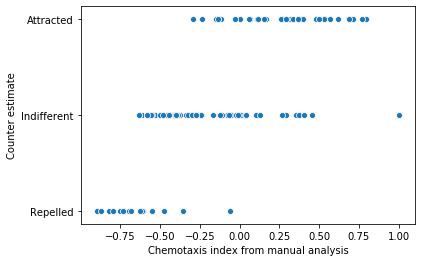

In [7]:
ax = sns.scatterplot(x='chemotaxis_index', y='impression_index', data=metadata)
ax.set_xlabel('Chemotaxis index from manual analysis')
ax.set_ylabel('Counter estimate')
ax.set_yticks([-0.5, 0, 0.5])
ax.set_yticklabels(['Repelled', 'Indifferent', 'Attracted']);

### Plot EVERYTHING

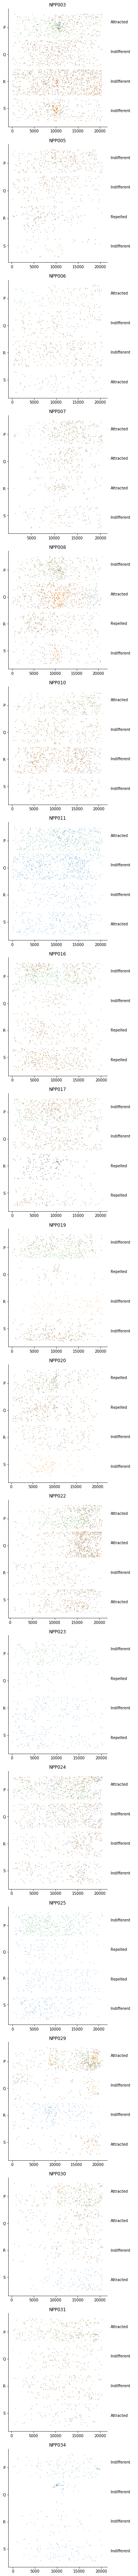

In [8]:
n_plates = len(manual_analysis_results['plate_id'].unique())
fig, axes = plt.subplots(nrows=n_plates, ncols=2, figsize=(5, 5 * n_plates),
                         constrained_layout=True, gridspec_kw={'width_ratios':[4,1]})

index = 0
# all_plates_with_some_analysis = [manual_analysis_results['plate_id'].unique()
for plate in manual_analysis_results['plate_id'].unique():
    sns.scatterplot(x='X', y='Y', hue='user', style='plate_id', legend=None, ax=axes[index, 0],
                    linewidth=0, alpha=0.5, s=3,
                    data=manual_analysis_results.loc[manual_analysis_results['plate_id'] == plate])

    try:
        automated_results_list = []
        for well_id in ['P']:#, 'Q', 'R', 'S']:
            automated_results = pd.read_csv(data_folder.parent.joinpath(
                'automated_analysis_results', plate + '_automatedAnalyzer_' + well_id +'.csv'))
            automated_results['plate_id'] = plate
            automated_results['well_id'] = well_id
            automated_results_list.append(automated_results)
        automated_results = pd.concat(automated_results_list)
        sns.scatterplot(x='Y', y='X', legend=None, ax=axes[index, 0],
                        linewidth=0, alpha=0.5, s=3, color=sns.color_palette()[2],
                        data=automated_results.loc[automated_results['plate_id'] == plate])
    except FileNotFoundError:
        print('No file', data_folder.parent.joinpath(
                'automated_analysis_results', plate + '_automatedAnalyzer_' + well_id +'.csv'))

    sns.despine()
#     axes[index, 0].set_xticks([0, 20000])
#     axes[index, 0].set_xticklabels(['Solvent', 'Compound'])
    axes[index, 0].get_xaxis().get_label().set_visible(False)

    axes[index, 0].set_yticks(list(range(int(30000/8), 30000, int(30000/4))))
    axes[index, 0].set_yticklabels(['P', 'Q', 'R', 'S'])
    axes[index, 0].get_yaxis().get_label().set_visible(False)

    axes[index, 0].invert_yaxis()
    axes[index, 0].set_title(plate)

    axes[index, 1].text(
        x=0, y=0,
        s=manual_analysis_results.loc[
            (manual_analysis_results['plate_id'] == plate) &
            (manual_analysis_results['well_id'] == 'P')][
            'user_impression'].values[0])
    axes[index, 1].text(
        x=0, y=1,
        s=manual_analysis_results.loc[
            (manual_analysis_results['plate_id'] == plate) &
            (manual_analysis_results['well_id'] == 'Q')][
            'user_impression'].values[0])
    axes[index, 1].text(
        x=0, y=2,
        s=manual_analysis_results.loc[
            (manual_analysis_results['plate_id'] == plate) &
            (manual_analysis_results['well_id'] == 'R')][
            'user_impression'].values[0])
    axes[index, 1].text(
        x=0, y=3,
        s=manual_analysis_results.loc[
            (manual_analysis_results['plate_id'] == plate) &
            (manual_analysis_results['well_id'] == 'S')][
            'user_impression'].values[0])
    axes[index, 1].set_ylim(-0.5, 3.5)
    axes[index, 1].axis('off')

    index += 1

fig.savefig(base_folder.joinpath('manual_analysis_results.pdf'))

In [9]:
automated_results_file = data_folder.parent.joinpath('chemotaxis_summary.csv')
automated_analysis_results = pd.read_csv(automated_results_file)
automated_analysis_results.rename(columns={'Plate_id': 'plate_id',
                                           'Well_id': 'well_id'}, inplace=True)
def add_strain(row, assay_metadata):
       
    strain = assay_metadata.loc[
        assay_metadata['plate_id']==row['plate_id']][
        'well_'+row['well_id']+'_strain']
    return strain.values[0]

def add_compound(row, assay_metadata):
    compound = assay_metadata.loc[
        assay_metadata['plate_id']==row['plate_id']]['compound']
    return compound.values[0]

automated_analysis_results['strain'] = automated_analysis_results.apply(
    lambda row: add_strain(row, assay_metadata), axis=1).astype('category')
automated_analysis_results['compound'] = automated_analysis_results.apply(
    lambda row: add_compound(row, assay_metadata), axis=1).astype('category')
automated_analysis_results['analysis_method'] = 'automated'

automated_analysis_results.columns

Index(['Unnamed: 0', 'plate_id', 'well_id', 'results_file', 'chemotaxis_index',
       'centroid_x', 'centroid_y', 'strain', 'compound', 'analysis_method'],
      dtype='object')

### Count total number of worms in each well for auto results

In [10]:
# well_results = []
# for one_well_auto_results_file in base_folder.joinpath('automated_analysis_results').glob('NPP*.csv'):
#     this_well_results = pd.read_csv(one_well_auto_results_file)
#     this_well_results['plate_id'] = one_well_auto_results_file.stem[0:6]
#     this_well_results['well_id'] = one_well_auto_results_file.stem[-1]
#     well_results.append(this_well_results)
    
# all_worms_automated_analysis = pd.concat(well_results)

def get_worm_count_from_auto_analysis(row):
    this_well_results = pd.read_csv(row['results_file'])
    return this_well_results.shape[0]

automated_analysis_results['total_worms'] = automated_analysis_results.apply(
    lambda row: get_worm_count_from_auto_analysis(row), axis=1)

count    144.000000
mean     235.756944
std      130.359656
min       39.000000
25%      151.750000
50%      207.500000
75%      281.000000
max      923.000000
Name: total_worms, dtype: float64

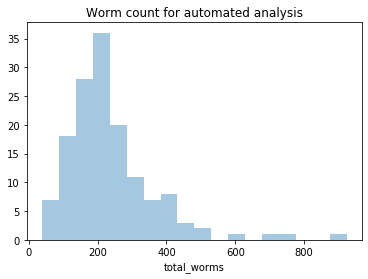

In [11]:
ax = sns.distplot(automated_analysis_results['total_worms'], kde=False)
ax.set_title('Worm count for automated analysis')
automated_analysis_results['total_worms'].describe()

count      76.000000
mean      311.796053
std       220.254734
min        48.000000
25%       157.625000
50%       270.250000
75%       417.125000
max      1275.500000
Name: mean, dtype: float64

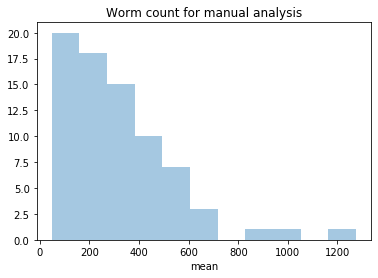

In [12]:
metadata['total_worms'] = metadata.apply(lambda row: row['worms_on_solvent_side'] + 
                                                     row['worms_on_neutral_side'] +
                                                     row['worms_on_compound_side'], axis=1)

ax =  sns.distplot(metadata.groupby(['plate_id', 'well_id']).describe()['total_worms']['mean'], kde=False)
ax.set_title('Worm count for manual analysis')
metadata.groupby(['plate_id', 'well_id']).describe()['total_worms']['mean'].describe()

In [13]:
metadata['strain'] = metadata.apply(
    lambda row: add_strain(row, assay_metadata), axis=1).astype('category')
metadata['compound'] = metadata.apply(
    lambda row: add_compound(row, assay_metadata), axis=1).astype('category')
metadata['analysis_method'] = 'manual'

In [14]:
combined_results = pd.concat([metadata[['plate_id',
                                       'well_id',
                                       'chemotaxis_index',
                                       'strain',
                                       'compound',
                                       'analysis_method',
                                       'total_worms']].copy(),
                             automated_analysis_results[['plate_id',
                                                         'well_id',
                                                         'chemotaxis_index',
                                                         'strain', 
                                                         'compound',
                                                         'analysis_method',
                                                         'total_worms']].copy()])

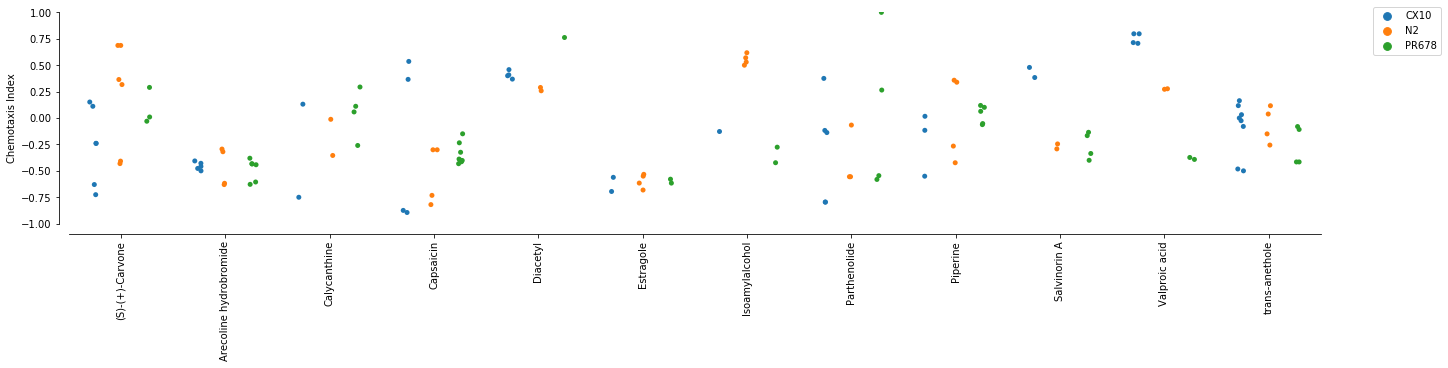

In [15]:
fig, ax = plt.subplots(figsize=(20, 5), constrained_layout=True)
sns.stripplot(x='compound', y='chemotaxis_index', ax=ax, dodge=True, #style='analysis_method',
              hue='strain', marker='o',
              data=combined_results.loc[combined_results['analysis_method']=='manual'])

ax.set_xlabel('')
ax.set_ylabel('Chemotaxis Index')
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_ylim((-1, 1))
sns.despine(offset=10)
plt.xticks(rotation=90)

fig.savefig('../chemotaxis_results_manual.pdf')

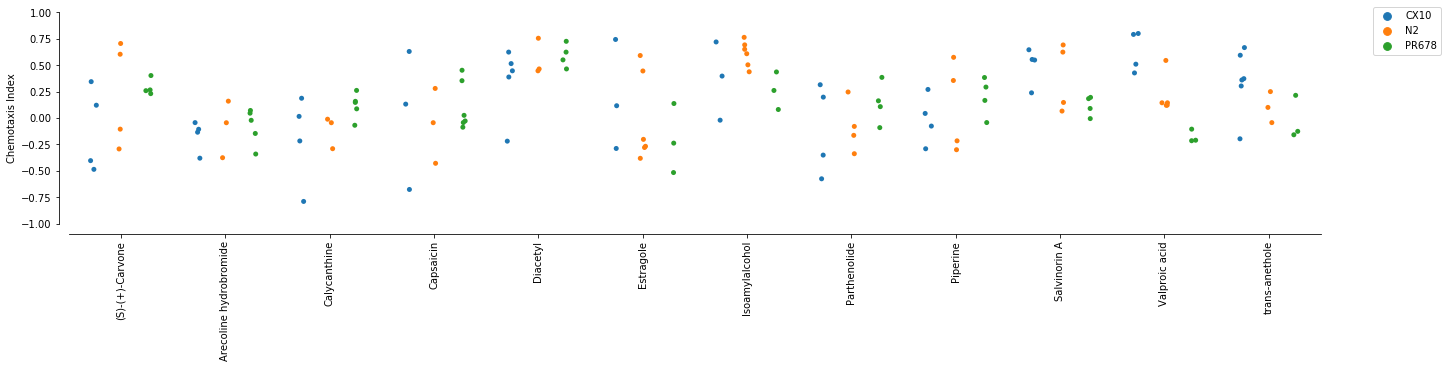

In [16]:
fig, ax = plt.subplots(figsize=(20, 5), constrained_layout=True)
sns.stripplot(x='compound', y='chemotaxis_index', ax=ax, dodge=True, #style='analysis_method',
              hue='strain', marker='o',
              data=combined_results.loc[combined_results['analysis_method']=='automated'])

ax.set_xlabel('')
ax.set_ylabel('Chemotaxis Index')
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_ylim((-1, 1))
sns.despine(offset=10)
plt.xticks(rotation=90)

fig.savefig('../chemotaxis_results_automated.pdf')

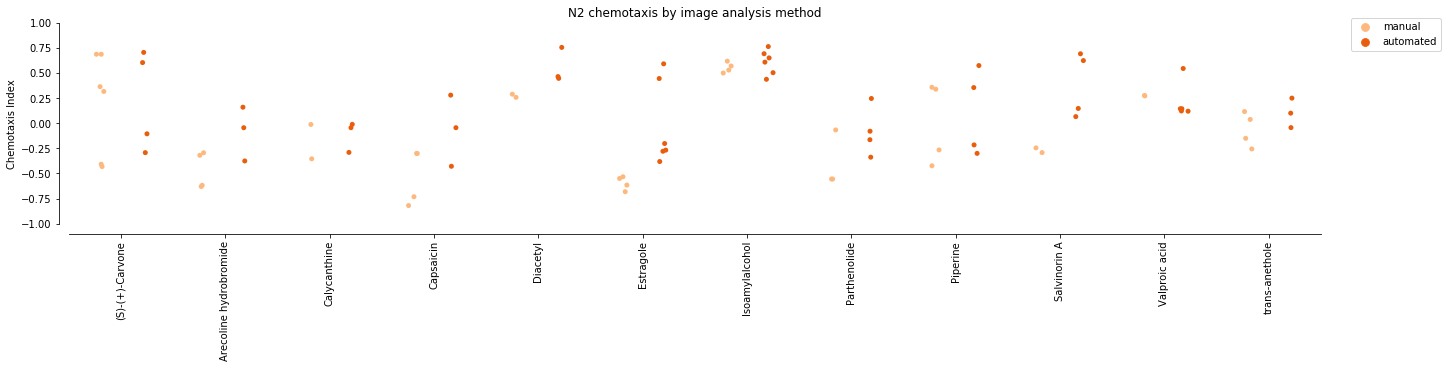

In [17]:
fig, ax = plt.subplots(figsize=(20, 5), constrained_layout=True)
sns.stripplot(x='compound', y='chemotaxis_index', ax=ax, dodge=True, #style='analysis_method',
              hue='analysis_method', marker='o', palette='Oranges',
              data=combined_results.loc[combined_results['strain']=='N2'])

ax.set_xlabel('')
ax.set_ylabel('Chemotaxis Index')
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_ylim((-1, 1))
sns.despine(offset=10)
plt.xticks(rotation=90)
ax.set_title('N2 chemotaxis by image analysis method')

fig.savefig('../N2_chemotaxis_results_auto_vs_manual.pdf')

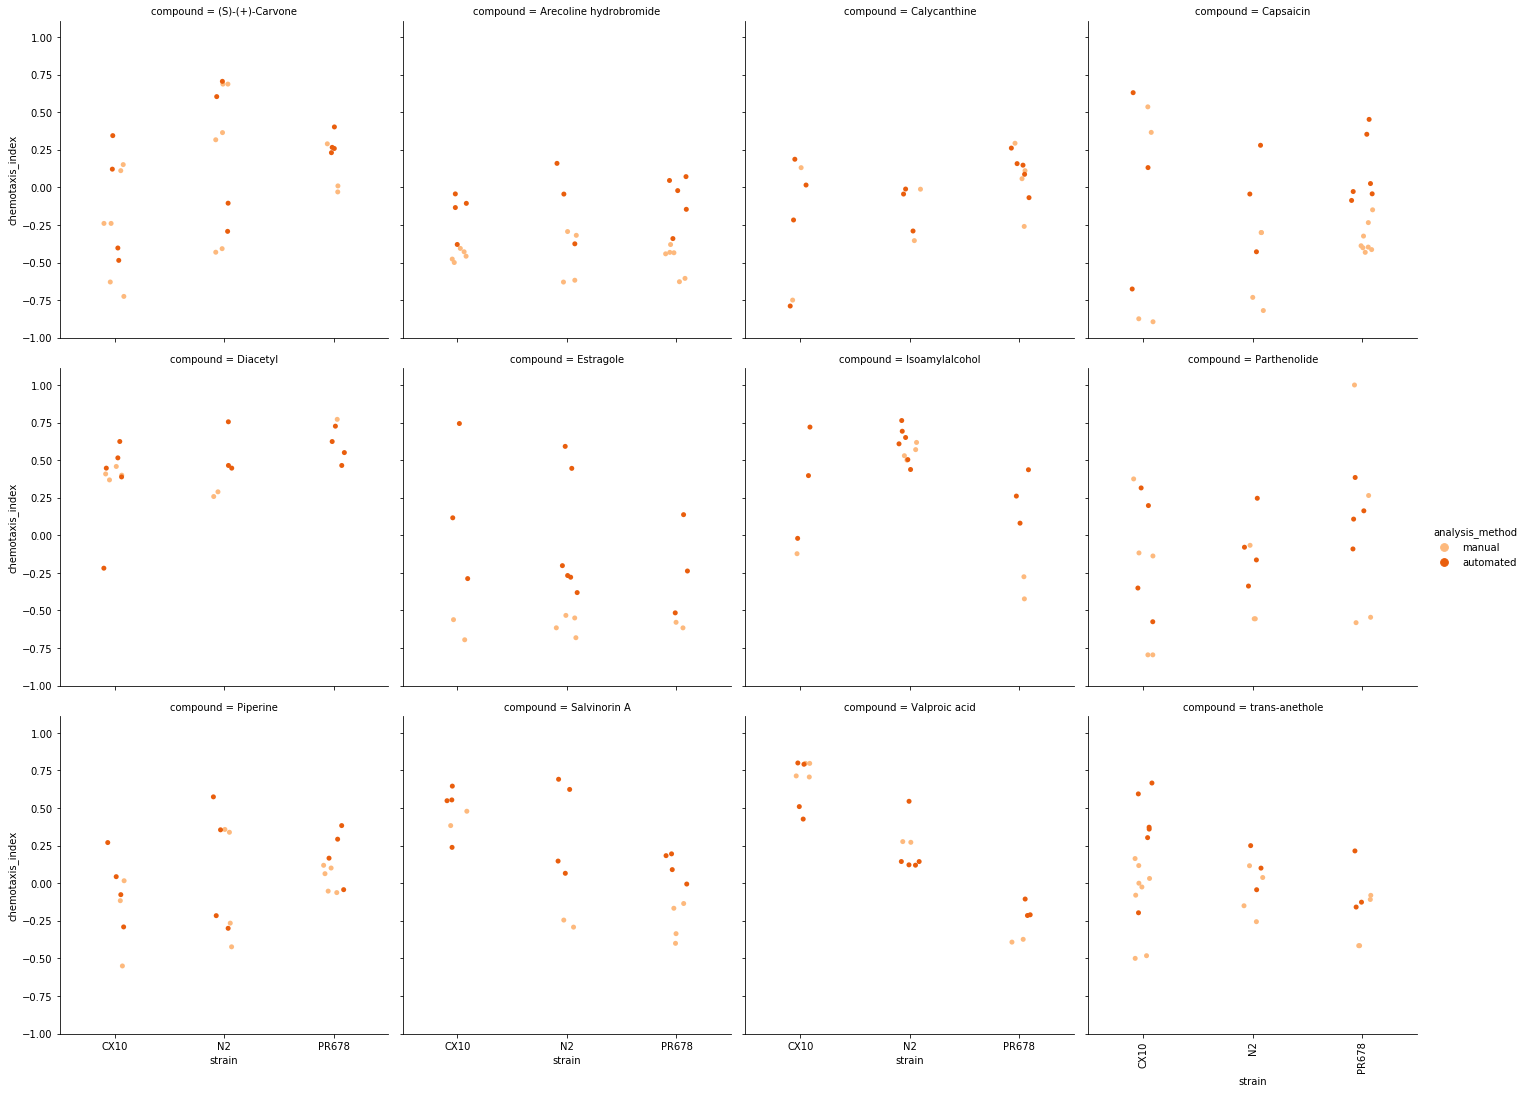

In [18]:
# fig, ax = plt.subplots(figsize=(20, 5), constrained_layout=True)

g = sns.catplot(x='strain', y='chemotaxis_index', hue='analysis_method',
                col='compound', data=combined_results, col_wrap=4, palette='Oranges')

ax.set_xlabel('')
ax.set_ylabel('Chemotaxis Index')
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_ylim((-1, 1))
sns.despine()
plt.xticks(rotation=90)
ax.set_title('N2 chemotaxis by image analysis method')

g.savefig('../all_results_by_compound.pdf')

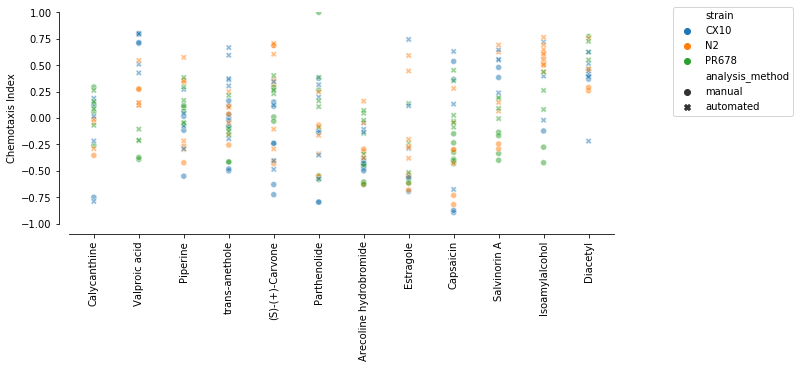

In [19]:
fig, ax = plt.subplots(figsize=(11, 5), constrained_layout=True)
sns.scatterplot(x='compound', y='chemotaxis_index', ax=ax, alpha=0.5,
              hue='strain', style='analysis_method',
              data=combined_results)

ax.set_xlabel('')
ax.set_ylabel('Chemotaxis Index')
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_ylim((-1, 1))
sns.despine(offset=10)
plt.xticks(rotation=90);

fig.savefig('../chemotaxis_results_by_analysis_method.pdf')

In [20]:
worms_by_manual_count = []
for index, manual_count in metadata.iterrows():
    this_manual_analysis = {
        'plate_id': manual_count['plate_id'],
        'well_id': manual_count['well_id'],
        'user': manual_count['user'],
        'strain': manual_count['strain'],
        'compound': manual_count['compound'],
        'total_worms_manual': manual_count['total_worms'],
        'manual_ci': manual_count['chemotaxis_index'],
        'total_worms_auto': automated_analysis_results.loc[
            (automated_analysis_results['plate_id']==manual_count['plate_id']) &
            (automated_analysis_results['well_id']==manual_count['well_id'])]['total_worms'].values[0],
        'auto_ci': automated_analysis_results.loc[
            (automated_analysis_results['plate_id']==manual_count['plate_id']) &
            (automated_analysis_results['well_id']==manual_count['well_id'])]['chemotaxis_index'].values[0]}
    worms_by_manual_count.append(this_manual_analysis)
worm_count_df = pd.DataFrame(worms_by_manual_count)

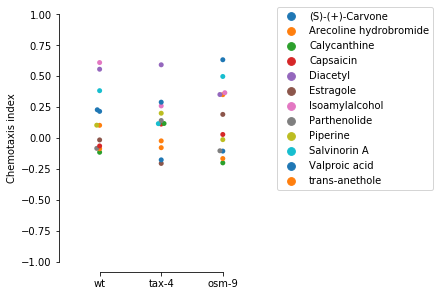

In [23]:
fig, ax = plt.subplots(constrained_layout=True)

sns.swarmplot(x='strain', y='chemotaxis_index', hue='compound', palette='tab10',
                   order=['N2', 'PR678', 'CX10'], ax=ax,
                   data=automated_analysis_results.groupby(
                           ['strain', 'compound']).mean().reset_index())
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_xticklabels(['wt', 'tax-4', 'osm-9'])
ax.set_xlabel('')
ax.set_ylabel('Chemotaxis index')
ax.set_ylim((-1, 1))
sns.despine(offset=10, trim=True)

fig.savefig(base_folder.joinpath('CI_by_strain_and_compound.pdf'))

LinregressResult(slope=0.4190371072402891, intercept=67.46137275319563, rvalue=0.9171058398484505, pvalue=9.060370678261172e-54, stderr=0.01597520209465374)


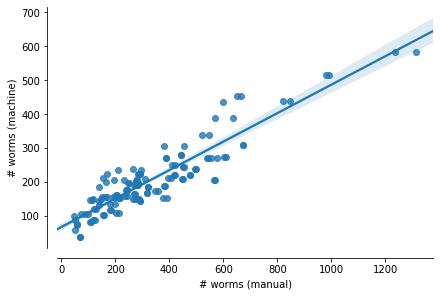

In [37]:
fig, ax = plt.subplots(constrained_layout=True)
sns.regplot(x='total_worms_manual', y='total_worms_auto', ax=ax,
                     data=worm_count_df)
ax.set_ylabel('# worms (machine)')
ax.set_xlabel('# worms (manual)')
sns.despine(offset=10)
fig.savefig(base_folder.joinpath('total_worms_man_vs_machine.pdf'))

fit_results = stats.linregress(
    worm_count_df['total_worms_manual'], worm_count_df['total_worms_auto'])
print(fit_results)


LinregressResult(slope=0.7519702943612786, intercept=0.19112419855629698, rvalue=0.9145038254115249, pvalue=6.201489149048178e-53, stderr=0.029177289389874624)


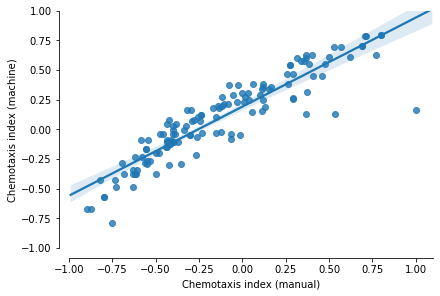

In [40]:
fig, ax = plt.subplots(constrained_layout=True)
ax = sns.regplot(x='manual_ci', y='auto_ci', ax=ax,
                     data=worm_count_df)
ax.set_ylabel('Chemotaxis index (machine)')
ax.set_xlabel('Chemotaxis index (manual)')
ax.set_ylim((-1, 1))
ax.set_xlim((-1, 1.1))
sns.despine(offset=10)

fig.savefig(base_folder.joinpath('ci_man_vs_machine.pdf'))

fit_results = stats.linregress(
    worm_count_df['manual_ci'], worm_count_df['auto_ci'])
print(fit_results)

LinregressResult(slope=0.00027595657491000935, intercept=0.13118116294818488, rvalue=0.3445590320725073, pvalue=5.218270095695904e-05, stderr=6.594200681224486e-05)


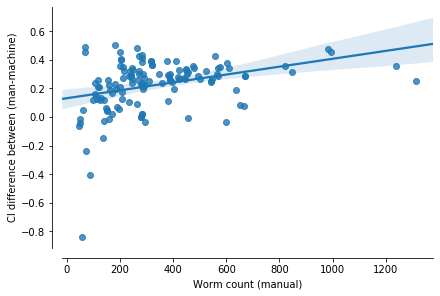

In [42]:
worm_count_df['ci_difference'] = worm_count_df['auto_ci'] - worm_count_df['manual_ci']
fig, ax = plt.subplots(constrained_layout=True)
ax = sns.regplot(x='total_worms_manual', y='ci_difference', ax=ax,
                     data=worm_count_df)
ax.set_ylabel('CI difference between (man-machine)')
ax.set_xlabel('Worm count (manual)')
sns.despine(offset=10)

fig.savefig(base_folder.joinpath('ci_diff_vs_machine_total.pdf'))

fit_results = stats.linregress(
    worm_count_df['total_worms_manual'], worm_count_df['ci_difference'])
print(fit_results)

In [27]:
combined_results['chemotaxis_index'].describe()

count    276.000000
mean       0.017251
std        0.414777
min       -0.894180
25%       -0.300699
50%        0.004854
75%        0.353761
max        1.000000
Name: chemotaxis_index, dtype: float64

In [44]:
worm_count_df.to_csv(base_folder.joinpath('worm_count_and_ci_plates_with_manual_analysis.csv'))

In [28]:
reorganized_results = combined_results.groupby(
    ['compound', 'strain', 'analysis_method']).describe(
    percentiles=[]).rename(columns={'50%':'median'})
reorganized_results.to_csv('../results_by_compound_with_stats.csv')

In [29]:
other_reorg = combined_results.groupby(
    ['compound', 'strain', 'analysis_method']).mean().unstack(level=-1)

other_reorg.to_csv('../results_by_compound.csv')

In [30]:
combined_results.to_csv('../chemotaxis_results.csv')

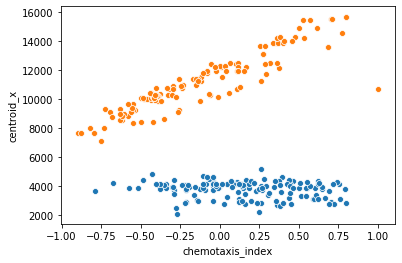

In [31]:
sns.scatterplot(x='chemotaxis_index', y='centroid_x', data=automated_analysis_results)
sns.scatterplot(x='chemotaxis_index', y='centroid_x', data=metadata)

In [32]:
print('Notebook took', str(int(time.time()-start)), 'seconds to run.')

Notebook took 67 seconds to run.
